# Learning parameters of univariate and multivariate normal distribution in PyTorch

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML, PyTorch]

In [1]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
dist = torch.distributions

#### Creating a 1d normal distribution

In [3]:
uv_normal = dist.Normal(loc=0.0, scale=1.0)

#### Sampling from the distribution

In [4]:
samples = uv_normal.sample(sample_shape=[1000])

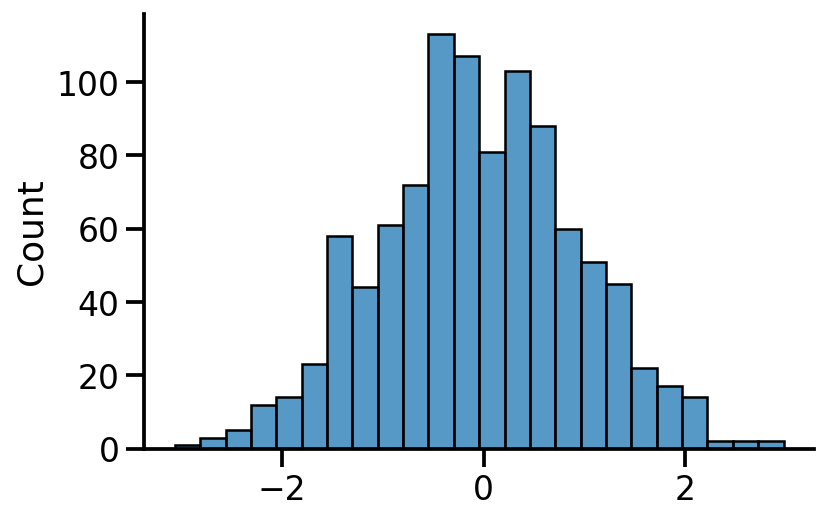

In [5]:
sns.histplot(samples)
sns.despine()

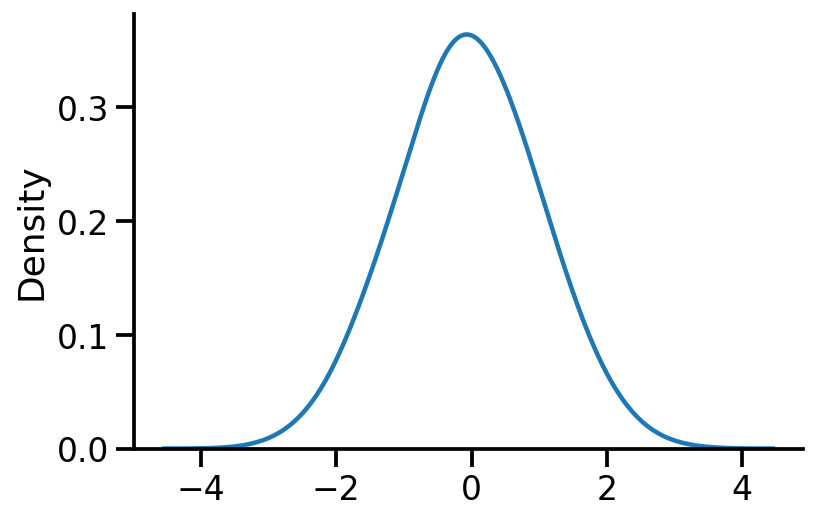

In [6]:
sns.kdeplot(samples, bw_adjust=2)
sns.despine()

#### Computing logprob and prob at a given x

Text(0.5, 1.0, 'Density at x = 0.5 is 0.35\n Logprob at x = 0.5 is -1.04')

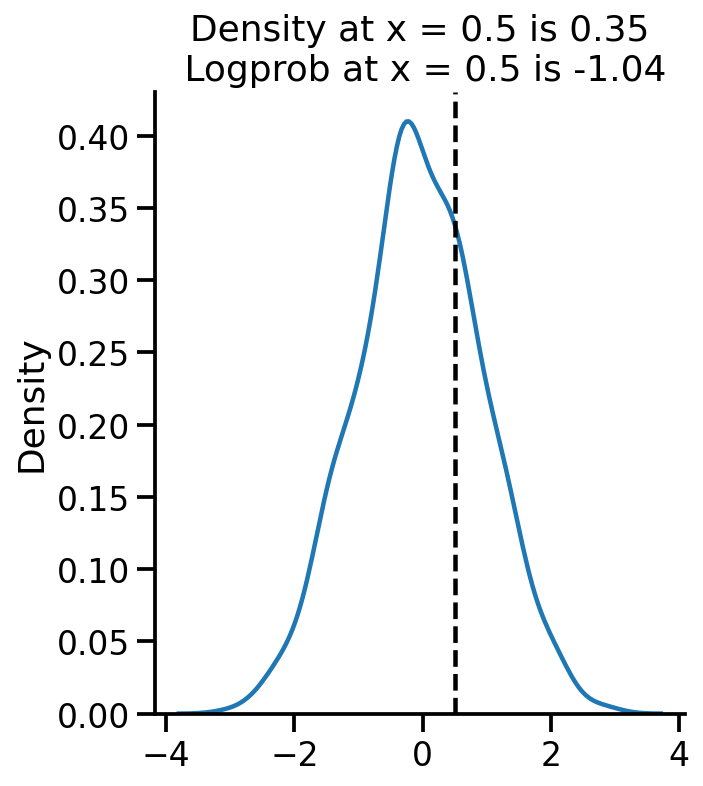

In [7]:
sns.displot(samples, kind="kde")
plt.axvline(0.5, color="k", linestyle="--")
log_pdf_05 = uv_normal.log_prob(torch.Tensor([0.5]))


pdf_05 = torch.exp(log_pdf_05)


plt.title(
    "Density at x = 0.5 is {:.2f}\n Logprob at x = 0.5 is {:.2f}".format(
        pdf_05.numpy()[0], log_pdf_05.numpy()[0]
    )
)

#### Learning parameters via MLE

Let us generate some normally distributed data and see if we can `learn` the mean.

In [8]:
train_data = uv_normal.sample([10000])

In [9]:
uv_normal.loc, uv_normal.scale

(tensor(0.), tensor(1.))

In [10]:
train_data.mean(), train_data.std()

(tensor(-0.0095), tensor(0.9998))

The above is the analytical MLE solution

##### Setting 1: Fixed scale, learning only location

In [11]:
loc = torch.autograd.Variable(torch.tensor(-10.0), requires_grad=True)
opt = torch.optim.Adam([loc], lr=0.01)
for i in range(3100):
    to_learn = torch.distributions.Normal(loc=loc, scale=1.0)
    loss = -torch.sum(to_learn.log_prob(train_data))
    loss.backward()
    if i % 500 == 0:
        print(f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc.item():0.2f}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 513239.44, Loc: -10.00
Iteration: 500, Loss: 170775.25, Loc: -5.61
Iteration: 1000, Loss: 47208.21, Loc: -2.58
Iteration: 1500, Loss: 18091.68, Loc: -0.89
Iteration: 2000, Loss: 14397.43, Loc: -0.21
Iteration: 2500, Loss: 14190.93, Loc: -0.04
Iteration: 3000, Loss: 14186.83, Loc: -0.01


In [12]:
print(
    f"MLE location gradient descent: {loc:0.2f}, MLE location analytical: {train_data.mean().item():0.2f}"
)

MLE location gradient descent: -0.01, MLE location analytical: -0.01


##### Setting 2: Learning location and scale

An important difference from the previous code is that we need to use a transformed variable to ensure scale is positive. We do so by using `softplus`.

In [13]:
loc = torch.autograd.Variable(torch.tensor(-10.0), requires_grad=True)
scale = torch.autograd.Variable(torch.tensor(2.0), requires_grad=True)

opt = torch.optim.Adam([loc, scale], lr=0.01)
for i in range(5100):
    scale_softplus = torch.functional.F.softplus(scale)

    to_learn = torch.distributions.Normal(loc=loc, scale=scale_softplus)
    loss = -torch.sum(to_learn.log_prob(train_data))
    loss.backward()
    if i % 500 == 0:
        print(
            f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc.item():0.2f}, Scale: {scale_softplus.item():0.2f}"
        )
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 128157.43, Loc: -10.00, Scale: 2.13
Iteration: 500, Loss: 37345.99, Loc: -6.86, Scale: 4.15
Iteration: 1000, Loss: 29958.72, Loc: -4.73, Scale: 4.59
Iteration: 1500, Loss: 26338.60, Loc: -2.87, Scale: 4.37
Iteration: 2000, Loss: 22609.89, Loc: -1.19, Scale: 3.46
Iteration: 2500, Loss: 15972.64, Loc: -0.06, Scale: 1.63
Iteration: 3000, Loss: 14186.80, Loc: -0.01, Scale: 1.00
Iteration: 3500, Loss: 14186.80, Loc: -0.01, Scale: 1.00
Iteration: 4000, Loss: 14186.80, Loc: -0.01, Scale: 1.00
Iteration: 4500, Loss: 14186.80, Loc: -0.01, Scale: 1.00
Iteration: 5000, Loss: 14186.80, Loc: -0.01, Scale: 1.00


In [14]:
print(
    f"MLE loc gradient descent: {loc:0.2f}, MLE loc analytical: {train_data.mean().item():0.2f}"
)
print(
    f"MLE scale gradient descent: {scale_softplus:0.2f}, MLE scale analytical: {train_data.std().item():0.2f}"
)

MLE loc gradient descent: -0.01, MLE loc analytical: -0.01
MLE scale gradient descent: 1.00, MLE scale analytical: 1.00


In [15]:
mvn = dist.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.tensor([[1., 0.5], [0.5, 2.]]))

In [16]:
mvn_samples = mvn.sample([1000])

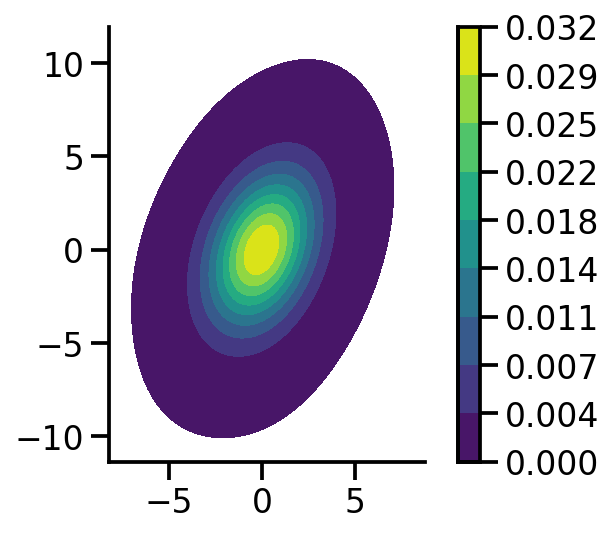

In [17]:
sns.kdeplot(x=mvn_samples[:, 0],
            y = mvn_samples[:, 1],zorder=0, n_levels=10, shade=True, 
    cbar=True, thresh=0.001, cmap='viridis',bw_adjust=5,  cbar_kws={'format': '%.3f', })

plt.gca().set_aspect('equal')
sns.despine()

##### Setting 1: Fixed scale, learning only location

In [18]:
loc = torch.autograd.Variable(torch.tensor([-10.0, 5.]), requires_grad=True)
opt = torch.optim.Adam([loc], lr=0.01)
for i in range(4100):
    to_learn = dist.MultivariateNormal(loc=loc, covariance_matrix=torch.tensor([[1., 0.5], [0.5, 2.]]))
    loss = -torch.sum(to_learn.log_prob(mvn_samples))
    loss.backward()
    if i % 500 == 0:
        print(f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 81670.56, Loc: tensor([-10.,   5.], requires_grad=True)
Iteration: 500, Loss: 23343.52, Loc: tensor([-5.6713,  0.9648], requires_grad=True)
Iteration: 1000, Loss: 7176.25, Loc: tensor([-2.7999, -0.8102], requires_grad=True)
Iteration: 1500, Loss: 3887.93, Loc: tensor([-1.1849, -0.8418], requires_grad=True)
Iteration: 2000, Loss: 3267.18, Loc: tensor([-0.4128, -0.3852], requires_grad=True)
Iteration: 2500, Loss: 3181.38, Loc: tensor([-0.1105, -0.1069], requires_grad=True)
Iteration: 3000, Loss: 3175.27, Loc: tensor([-0.0237, -0.0187], requires_grad=True)
Iteration: 3500, Loss: 3175.09, Loc: tensor([-0.0078, -0.0023], requires_grad=True)
Iteration: 4000, Loss: 3175.09, Loc: tensor([-0.0062, -0.0006], requires_grad=True)


In [19]:
loc, mvn_samples.mean(axis=0)

(tensor([-0.0062, -0.0005], requires_grad=True), tensor([-0.0061, -0.0005]))

We can see that our approach yields the same results as the analytical MLE

##### Setting 2: Learning scale and location

We need to now choose the equivalent of standard deviation in MVN case, this is the Cholesky matrix which should be a lower triangular matrix

In [20]:
loc = torch.autograd.Variable(torch.tensor([-10.0, 5.]), requires_grad=True)
tril = torch.autograd.Variable(torch.tril(torch.ones(2, 2)), requires_grad=True)
opt = torch.optim.Adam([loc, tril], lr=0.01)

for i in range(8100):
    to_learn = dist.MultivariateNormal(loc=loc, covariance_matrix=tril@tril.t())
    loss = -torch.sum(to_learn.log_prob(mvn_samples))
    loss.backward()
    if i % 500 == 0:
        print(f"Iteration: {i}, Loss: {loss.item():0.2f}, Loc: {loc}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 165798.23, Loc: tensor([-10.,   5.], requires_grad=True)
Iteration: 500, Loss: 9570.80, Loc: tensor([-7.8981,  3.2962], requires_grad=True)
Iteration: 1000, Loss: 6482.00, Loc: tensor([-6.4115,  2.5039], requires_grad=True)
Iteration: 1500, Loss: 5326.22, Loc: tensor([-5.0748,  1.8930], requires_grad=True)
Iteration: 2000, Loss: 4729.28, Loc: tensor([-3.8370,  1.3698], requires_grad=True)
Iteration: 2500, Loss: 4374.35, Loc: tensor([-2.6961,  0.9158], requires_grad=True)
Iteration: 3000, Loss: 4143.88, Loc: tensor([-1.6821,  0.5356], requires_grad=True)
Iteration: 3500, Loss: 3975.60, Loc: tensor([-0.8552,  0.2465], requires_grad=True)
Iteration: 4000, Loss: 3816.21, Loc: tensor([-0.2941,  0.0693], requires_grad=True)
Iteration: 4500, Loss: 3593.16, Loc: tensor([-0.0433,  0.0044], requires_grad=True)
Iteration: 5000, Loss: 3239.28, Loc: tensor([-0.0062, -0.0006], requires_grad=True)
Iteration: 5500, Loss: 3172.94, Loc: tensor([-0.0061, -0.0005], requires_grad=True)


In [21]:
to_learn.loc, to_learn.covariance_matrix

(tensor([-0.0061, -0.0005], grad_fn=<AsStridedBackward0>),
 tensor([[1.0271, 0.4888],
         [0.4888, 2.1354]], grad_fn=<ExpandBackward0>))

In [22]:
mle_loc = mvn_samples.mean(axis=0)
mle_loc

tensor([-0.0061, -0.0005])

In [23]:
mle_covariance = (mvn_samples - mle_loc).t()@((mvn_samples - mle_loc))/mvn_samples.shape[0]
mle_covariance

tensor([[1.0271, 0.4888],
        [0.4888, 2.1354]])

We can see that our gradient based methods parameters match those of the MLE computed analytically.

References

1. https://stats.stackexchange.com/questions/351549/maximum-likelihood-estimators-multivariate-gaussian
2. https://forum.pyro.ai/t/mle-for-normal-distribution-parameters/3861/3
3. https://ericmjl.github.io/notes/stats-ml/estimating-a-multivariate-gaussians-parameters-by-gradient-descent/